# Odd Galaxy Classifier

In this notebook we use Model III by Ghaderi et al. (2025) (https://iopscience.iop.org/article/10.3847/1538-4365/ada8ab) to classify odd galaxies. Their original code is publically available on GitHub at: https://github.com/hmddev1/machine_learning_for_morphological_galaxy_classificatio

In [ ]:
import os
path = '/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier'
os.chdir(path)

In [ ]:
# Installing dependencies not pre-installed on Colab
# !pip install tensorflow -q
# !pip install opencv-python -q

In [ ]:
# Importing dependencies
%run ../imports.py
%matplotlib inline

In [ ]:
# Importing custom modules
import sys
import importlib.util

file_path = "../plotting.py"
module_name = "plotting"

spec = importlib.util.spec_from_file_location(module_name, file_path)
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

In [ ]:
# Fixing seeds for maximum reproducibility
random.seed(42) # Python built-in random
np.random.seed(42) # NumPy
tf.random.set_seed(42) # TensorFlow

Two debiased Galaxy Zoo tables are provided on the Galaxy Zoo website. The website strongly advises the use of the Hart et al. (2016) table, as this debiases the GZ2 question tree most consistently. In this notebook, we will work with this table.

In [ ]:
df = pd.read_csv('gz2_hart16.csv')

In [ ]:
# Dropping objects that are either stars or artifacts
df = df.drop(labels=np.where(df['gz2_class'] == 'A')[0], axis=0)

# Choosing objects that over 80% of volunteers said were odd
df = df[df['t06_odd_a14_yes_fraction'] > 0.80]

# Resetting inices to avoid confusion
df = df.reset_index(drop=True)

Any feature in the galaxy users identified as “odd” appears at the end of the string in parentheses: '(r)'=ring, '(l)'=lens/arc, '(d)'=disturbed, '(i)'=irregular, '(o)'=other, '(m)'=merger, '(u)'=dust lane. We keep only these classes.

In [ ]:
classes_to_keep = [i for i in df['gz2_class'].unique() if any(j in i for j in ['(', ')'])]

In [ ]:
classes_to_drop = [i for i in df['gz2_class'].unique() if i not in classes_to_keep]

In [ ]:
mask = df['gz2_class'].isin(classes_to_drop)
indices_to_drop = np.where(mask)[0]

In [ ]:
df = df.drop(labels=indices_to_drop, axis=0)

In [ ]:
odd_df = df.reset_index(drop=True)

In [ ]:
odd_df.head(5)

,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587741602562310202,167.855057,26.963604,11:11:25.21,+26:57:49.0,original,Ei(m),42,191,28,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
1,587726102027239592,229.454895,4.162598,15:17:49.17,+04:09:45.4,extra,Sc(u),28,139,9,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
2,587736543095947393,224.399216,8.285270,14:57:35.81,+08:17:07.0,original,Sc?t(r),44,328,3,...,0.040,0.040,0.044558,0,18,18.0,0.720,0.720,0.706595,0
3,587735349099954195,156.442764,13.716849,10:25:46.26,+13:43:00.7,original,Sb2l(m),43,360,2,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
4,587731874460991570,121.367149,35.946690,08:05:28.12,+35:56:48.1,original,Sb(r),43,283,8,...,0.143,0.143,0.155321,0,4,4.0,0.571,0.571,0.564174,0


In [ ]:
# Sanity check: Are they really all classified as odd?
int(odd_df['gz2_class'].isin(['(', ')']).value_counts()[0]) - len(odd_df)

0

Now we will rename the classes.

In [ ]:
naming_dict = {'(r)' : 'Ring',
               '(l)' : 'Lens',
               '(d)' : 'Disturbed',
               '(i)' : 'Irregular',
               '(o)' : 'Other',
               '(m)' : 'Merger',
               '(u)' : 'Dust Lane'}

In [ ]:
gz2_class = [naming_dict[i[-3:]] for i in df['gz2_class']]

In [ ]:
odd_df['gz2_class'] = gz2_class

In [ ]:
odd_df.head(5)

,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587741602562310202,167.855057,26.963604,11:11:25.21,+26:57:49.0,original,Merger,42,191,28,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
1,587726102027239592,229.454895,4.162598,15:17:49.17,+04:09:45.4,extra,Dust Lane,28,139,9,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
2,587736543095947393,224.399216,8.285270,14:57:35.81,+08:17:07.0,original,Ring,44,328,3,...,0.040,0.040,0.044558,0,18,18.0,0.720,0.720,0.706595,0
3,587735349099954195,156.442764,13.716849,10:25:46.26,+13:43:00.7,original,Merger,43,360,2,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
4,587731874460991570,121.367149,35.946690,08:05:28.12,+35:56:48.1,original,Ring,43,283,8,...,0.143,0.143,0.155321,0,4,4.0,0.571,0.571,0.564174,0


In [ ]:
odd_df.shape

(5287, 231)

In [ ]:
# Count classes
classes = np.unique(odd_df['gz2_class'])
class_counts = []
for class_name in classes:
  class_count = len(np.where(odd_df['gz2_class'] == class_name)[0])
  class_counts.append(class_count)

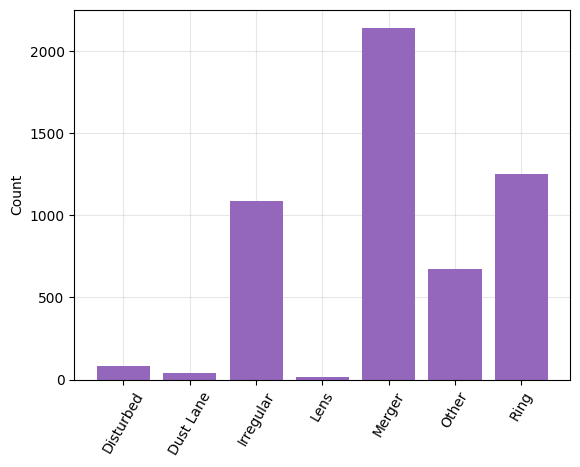

In [ ]:
# Visualize distribution of classes
plt.figure(dpi=100)
plt.bar(classes, class_counts, label=classes, color='tab:purple', zorder=2)
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.grid(True, alpha=0.3, zorder=1)
plt.show()

In [ ]:
len(np.where(odd_df['gz2_class'] == 'Dust Lane')[0])

37

In [ ]:
len(np.where(odd_df['gz2_class'] == 'Lens')[0])

15

In [ ]:
len(np.where(odd_df['gz2_class'] == 'Disturbed')[0])

84

As we can, the classes are imbalanced. This will be addressed later when we build our classifier model.

In [ ]:
# Paths to image data
r_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/ring'
l_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/lens'
d_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/disturbed'
i_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/irregular'
o_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/other'
m_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/merger'
u_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Models/Odd Classifier/data_reduced/dust_lane'

# Default image size
image_size = 200

In [ ]:
# Defining functions to crop the images

from skimage.transform import resize
from skimage.measure import label, regionprops

def find_largest_object(binary_mask):
    """Find the largest connected component in the binary mask."""
    labeled = label(binary_mask)
    regions = regionprops(labeled)

    if not regions:
        return binary_mask  # Return as-is if no objects detected

    largest_region = max(regions, key=lambda r: r.area)
    mask = np.zeros_like(binary_mask)
    mask[tuple(largest_region.coords.T)] = 1
    return mask

def segment_galaxy(img):
    """Segment the main galaxy using thresholding and morphological operations."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding to remove background noise
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean noise
    kernel = np.ones((5, 5), np.uint8)
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find the largest bright object (assumed to be the galaxy)
    mask = find_largest_object(opened)
    return mask

def crop_galaxy(img, mask):
    """Extract the bounding box of the detected galaxy and resize it."""
    y_indices, x_indices = np.where(mask > 0)

    if len(x_indices) == 0 or len(y_indices) == 0:
        return None  # No valid segmentation

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Add padding
    pad = 20
    x_min, x_max = max(x_min - pad, 0), min(x_max + pad, img.shape[1])
    y_min, y_max = max(y_min - pad, 0), min(y_max + pad, img.shape[0])

    cropped = img[y_min:y_max, x_min:x_max]

    # Resize to standard dimensions
    final_size = 256
    resized = resize(cropped, (final_size, final_size))
    return resized

In [ ]:
def crop_images(image_path, cropped_images):

    # Create output folder if it doesn't exist
    os.makedirs(cropped_images, exist_ok=True)

    # Get list of image files
    image_files = [os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.jpg')]

    # Iterate through images and perform cropping
    cropped_image_count = 0
    for img_path in tqdm(image_files, desc="Processing images", unit="image"):
        img = cv2.imread(img_path)
        mask = segment_galaxy(img)
        cropped = crop_galaxy(img, mask)

        if cropped is not None:
            # Save the cropped image
            output_path = os.path.join(cropped_images, os.path.basename(img_path))
            cv2.imwrite(output_path, (cropped * 255).astype(np.uint8))
            cropped_image_count += 1

    print(f"Total number of cropped images: {cropped_image_count}")

In [ ]:
# Paths to images and output folder
image_paths = ['ring','lens','disturbed','irregular','other','merger','dust_lane']

# Create cropped directory
os.makedirs(r'data_reduced/data_cropped/', exist_ok=True)

for path in image_paths:
    image_path = r'data_reduced/'+path
    cropped_images = r'data_reduced/data_cropped/'+path+'_cropped'
    crop_images(image_path, cropped_images)

In [ ]:
# Defining function that loads image data
def load_galaxy_images(data_dir, target_size, sample_size=None):
        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).
        sample_size (int): The sample size.

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        if sample_size:
          file_path = file_path[:sample_size]

        for img in tqdm(file_path, desc="Processing images", unit="image"):
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

In [ ]:
# Paths to cropped image data
r_path = r'data_reduced/data_cropped/ring_cropped'
l_path = r'data_reduced/data_cropped/lens_cropped'
d_path = r'data_reduced/data_cropped/disturbed_cropped'
i_path = r'data_reduced/data_cropped/irregular_cropped'
o_path = r'data_reduced/data_cropped/other_cropped'
m_path = r'data_reduced/data_cropped/merger_cropped'
u_path = r'data_reduced/data_cropped/dust_lane_cropped'

# Default image size
image_size = 200 # The original size is 424!

In [ ]:
# WARNING: This cell takes a while!
# Loading image data
r_img = load_galaxy_images(r_path, target_size=(image_size,image_size), sample_size=None)
l_img = load_galaxy_images(l_path, target_size=(image_size,image_size), sample_size=None)
d_img = load_galaxy_images(d_path, target_size=(image_size,image_size), sample_size=None)
i_img = load_galaxy_images(i_path, target_size=(image_size,image_size), sample_size=None)
o_img = load_galaxy_images(o_path, target_size=(image_size,image_size), sample_size=None)
m_img = load_galaxy_images(m_path, target_size=(image_size,image_size), sample_size=None)
u_img = load_galaxy_images(u_path, target_size=(image_size,image_size), sample_size=None)

In [ ]:
# Combining the data
all_data = r_img + l_img + d_img + i_img + o_img + m_img + u_img
np.shape(all_data)

In [ ]:
# Labeling the data
label_r = [0] * len(r_img)
label_l = [1] * len(l_img)
label_d = [2] * len(d_img)
label_i = [3] * len(i_img)
label_o = [4] * len(o_img)
label_m = [5] * len(m_img)
label_u = [6] * len(u_img)

all_labels = label_r + label_l + label_d + label_i + label_o + label_m + label_u
len(all_labels)

In [ ]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_data) / (7*len(r_img)),
                 1: len(all_data) / (7*len(l_img)),
                 2: len(all_data) / (7*len(d_img)),
                 3: len(all_data) / (7*len(i_img)),
                 4: len(all_data) / (7*len(o_img)),
                 5: len(all_data) / (7*len(m_img)),
                 6: len(all_data) / (7*len(u_img))}

In [ ]:
np.shape(all_data)

(5149, 200, 200, 3)

In [ ]:
len(all_labels)

5149

### Testing cropping on lens morphologies
Here, we test whether the cropping is done well for lensed morphologies which have a lot of features. In our report we make arguments regarding the cropping and how it may affect the performance of the classifier. We also show a figure that describes how the images are processed. The following is the respective code for that figure. We have commented this code out as it is not relevant to the training of the model.

In [ ]:
# ls data_reduced/lens/

In [ ]:
# # Load original image
# img_file = '36865.jpg'
# img_path = 'data_reduced/lens/'+img_file
# original = cv2.imread(img_path)
# original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# # Load cropped image
# cropped_path = 'data_reduced/data_cropped/lens_cropped/'+img_file
# cropped = cv2.imread(cropped_path)
# cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB) # Convert to RGB for correct colors

# # Resize image
# target_size = (image_size, image_size)
# resized = cv2.resize(cropped, target_size)
# resized = (resized * 255).astype(np.uint8) # Scale pixel values from [0,1] to [0,255] range
# pil_resized = Image.fromarray(resized)

# # Apply transformations
# train_transform = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.RandomRotation(90),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# transformed = train_transform(pil_resized)
# transformed_np = np.transpose(transformed.numpy(), (1, 2, 0))
# transformed_np = cv2.cvtColor(transformed_np, cv2.COLOR_BGR2RGB)

# # Plot images
# fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=100)
# axes[0].imshow(original)
# axes[0].set_title("Original")
# axes[0].axis("off")

# axes[1].imshow(cropped)
# axes[1].set_title("Cropped")
# axes[1].axis("off")

# axes[2].imshow(pil_resized)
# axes[2].set_title("Resized")
# axes[2].axis("off")

# axes[3].imshow(transformed_np)
# axes[3].set_title("Transformed")
# axes[3].axis("off")

# plt.show()

The cropping is satisfactory but the background is reduced significantly which may affect the ability of the models to correctly classify lensed galaxies for the identification of which the background plays an important role.

#### We are finally ready to build our model.

In [ ]:
# Transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# Transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=4) # Change class number here

In [ ]:
# Reducing dataset to avoid overloading RAM
train_samples = 1500
test_samples = int(train_samples*0.25)

X_train, X_test, y_train, y_test, train_indices, test_indices = X_train[:train_samples], X_test[:test_samples], y_train[:train_samples], y_test[:test_samples], train_indices[:train_samples], test_indices[:test_samples]

y_train_encoded = to_categorical(y_train, num_classes=4) # Change class number here

In [ ]:
# WARNING: This cell takes a while!
# Transforming training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transforming testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

In [ ]:
# Building the model

# input
x = Input(shape=(image_size,image_size,3))

#hidden layers
c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(m2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(4, activation='softmax')(de1) # Change class number here

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_transformer_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 200, 200, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940,068 (11.22 MB)

 Trainable params: 2,939,172 (11.21 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Training the model
b_size = 64
e_num = 30

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3854 - loss: 2.1403 - val_accuracy: 0.2733 - val_loss: 6.7207
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 418ms/step - accuracy: 0.3851 - loss: 0.8372 - val_accuracy: 0.2667 - val_loss: 2.6517
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.4740 - loss: 0.6942 - val_accuracy: 0.3600 - val_loss: 1.4038
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.5324 - loss: 0.5933 - val_accuracy: 0.3933 - val_loss: 1.2477
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.5476 - loss: 0.5620 - val_accuracy: 0.3933 - val_loss: 1.2798
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.6005 - loss: 0.5248 - val_accuracy: 0.3333 - val_loss: 1.3449
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.6134 - loss: 0.4999 - val_accuracy: 0.2733 - val_loss: 1.8555
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.5412 - loss: 0.6255 - val_accuracy:

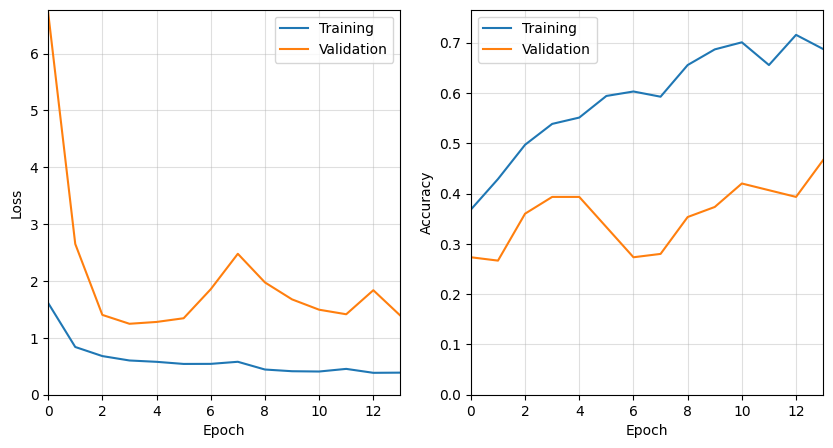

In [ ]:
plotting.plot_model_history(history)

In [ ]:
# Making predictions on unseen data (test set)
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 440ms/step


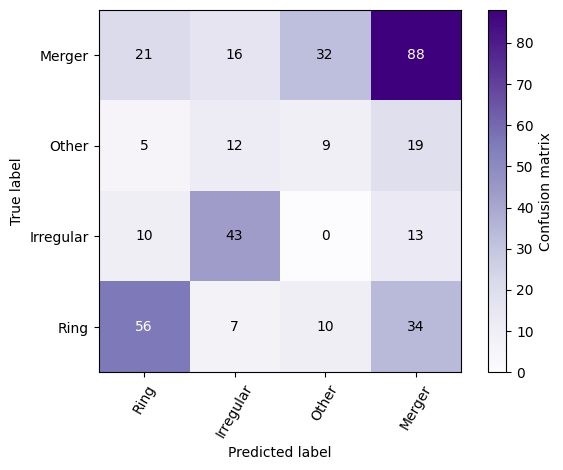

In [ ]:
# Confusion matrix
# class_names = ['Ring', 'Lens', 'Disturbed', 'Irregular', 'Other', 'Merger', 'Dust Lane']
class_names = ['Ring', 'Irregular', 'Other', 'Merger']
plotting.plot_confusion_matrix(np.array(y_test), np.array(y_pred_labels), classes=class_names, cmap=plt.cm.Purples, normalize=False, x_tick_rot=60)

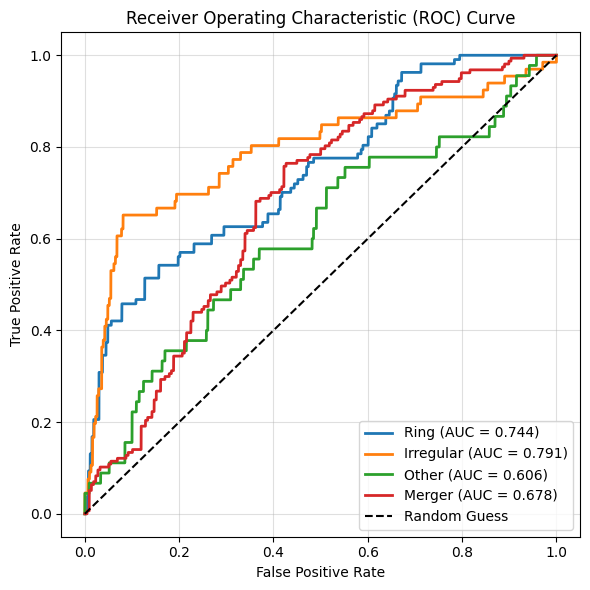

In [ ]:
# Computing the ROC Curve
num_classes = 4
y_score = y_pred  # Use predicted probabilities for ROC curve
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))  # Binarize the true labels

# Computing True Positive and False Positive Rates for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))

# Plotting the ROC curve for each class
for i in range(num_classes):  # Iterate through each class
  tprs_interp = []
  for j in range(len(fpr)):
      tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

  mean_tpr = np.mean(tprs_interp, axis=0)
  mean_auc = np.trapz(mean_tpr, mean_fpr)

  ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
ax.grid(alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# Performance
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.5226666666666666
Precision: 0.5311213662722614
F1_score: 0.5251310581130016
Accuracy: 0.5226666666666666


In [ ]:
z# Use the confusion matrix to calculate the True Skill Score (TSS) for every class
tss_per_class = {}
cm = confusion_matrix(y_test, y_pred_labels)
for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements
    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss
    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Ring' class: 0.38903612777235314
TSS for 'Irregular' class: 0.538246543100912
TSS for 'Other' class: 0.07272727272727275
TSS for 'Merger' class: 0.2577572605621457


### Other models to try in the future

In [ ]:
# DenseNet-121 architecture
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        b = BatchNormalization()(x)
        r = tf.keras.layers.ReLU()(b)
        c = Conv2D(4 * growth_rate, (1,1), padding='same', use_bias=False)(r)
        b = BatchNormalization()(c)
        r = tf.keras.layers.ReLU()(b)
        c = Conv2D(growth_rate, (3,3), padding='same', use_bias=False)(r)
        x = tf.keras.layers.Concatenate()([x, c])
    return x

def transition_layer(x, out_channels):
    b = BatchNormalization()(x)
    r = tf.keras.layers.ReLU()(b)
    c = Conv2D(out_channels, (1,1), padding='same', use_bias=False)(r)
    p = MaxPooling2D(pool_size=(2,2), strides=2)(c)  # downsampling
    return p

# Input
x = Input(shape=(image_size, image_size, 3))

# Initial Convolution
c0 = Conv2D(64, (7,7), strides=2, padding='same', use_bias=False)(x)
b0 = BatchNormalization()(c0)
r0 = tf.keras.layers.ReLU()(b0)
m0 = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(r0)

# Dense Blocks and Transition Layers
growth_rate = 32
num_layers = [6, 12, 24, 16]

d1 = dense_block(m0, num_layers[0], growth_rate)
t1 = transition_layer(d1, 128)

d2 = dense_block(t1, num_layers[1], growth_rate)
t2 = transition_layer(d2, 256)

d3 = dense_block(t2, num_layers[2], growth_rate)
t3 = transition_layer(d3, 512)

d4 = dense_block(t3, num_layers[3], growth_rate)

# Global Pooling & Fully Connected Layers
g = GlobalAveragePooling2D()(d4)
de0 = Dense(64, activation='relu')(g)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(7, activation='softmax')(de1)  # adjust number of classes

# Model
model = Model(inputs=x, outputs=de2, name="densenet_cnn_transformer")

# Compilation
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # from_logits=False since softmax is applied
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Summary
model.summary()